# Image recognition of Anderson states

## Preliminaries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
#bs = 64
bs = 4  # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Reading in the image data

In [4]:
path = Path('/media/phsht/DataDrive/MachineLearning/MachineLearning-Anderson/data-L50-1000-CO-NF')

In [5]:
path.ls()

[PosixPath('/media/phsht/DataDrive/MachineLearning/MachineLearning-Anderson/data-L50-1000-CO-NF/W16.2'),
 PosixPath('/media/phsht/DataDrive/MachineLearning/MachineLearning-Anderson/data-L50-1000-CO-NF/W16.6'),
 PosixPath('/media/phsht/DataDrive/MachineLearning/MachineLearning-Anderson/data-L50-1000-CO-NF/models'),
 PosixPath('/media/phsht/DataDrive/MachineLearning/MachineLearning-Anderson/data-L50-1000-CO-NF/W15.25'),
 PosixPath('/media/phsht/DataDrive/MachineLearning/MachineLearning-Anderson/data-L50-1000-CO-NF/W16.3'),
 PosixPath('/media/phsht/DataDrive/MachineLearning/MachineLearning-Anderson/data-L50-1000-CO-NF/W15.5'),
 PosixPath('/media/phsht/DataDrive/MachineLearning/MachineLearning-Anderson/data-L50-1000-CO-NF/W16.7'),
 PosixPath('/media/phsht/DataDrive/MachineLearning/MachineLearning-Anderson/data-L50-1000-CO-NF/W16.0'),
 PosixPath('/media/phsht/DataDrive/MachineLearning/MachineLearning-Anderson/data-L50-1000-CO-NF/W16.4'),
 PosixPath('/media/phsht/DataDrive/MachineLearning/Ma

In [6]:
np.random.seed(1234567)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(do_flip=False,max_rotate=0.,max_warp=0.,max_zoom=1.0,max_lighting=None), 
                                  size=256, num_workers=4).normalize(imagenet_stats)

In [7]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['W15.0',
  'W15.25',
  'W15.5',
  'W15.75',
  'W16.0',
  'W16.2',
  'W16.3',
  'W16.4',
  'W16.5',
  'W16.6',
  'W16.7',
  'W16.8',
  'W17.0',
  'W17.25',
  'W17.5',
  'W17.75',
  'W18.0'],
 17,
 13600,
 3400)

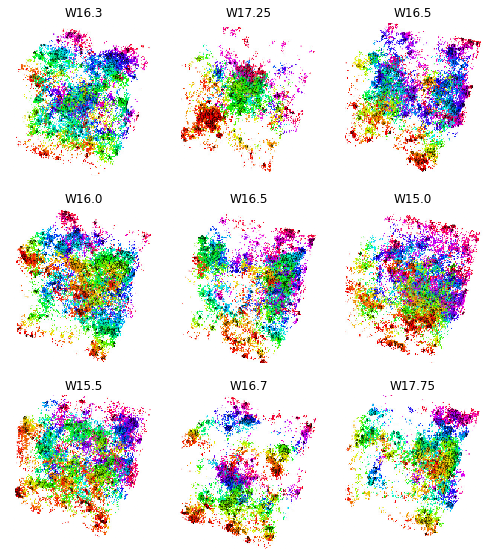

In [8]:
data.show_batch(rows=3, figsize=(7,8))

## Train model

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)#.to_fp16()

In [10]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [11]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
___________________________________________________

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


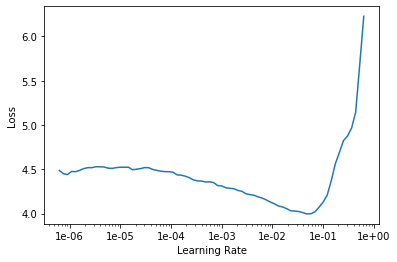

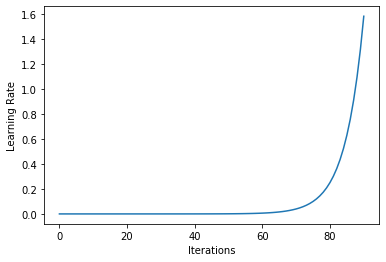

In [12]:
learn.lr_find()
learn.recorder.plot()
learn.recorder.plot_lr()

In [13]:
lr=1.e-2

In [ ]:
learn.fit_one_cycle(10,lr)

epoch,train_loss,valid_loss,error_rate,time
0,2.827688,9.479563,0.874706,01:40
1,2.497192,152.917053,0.905000,01:10
2,2.518064,4.122137,0.890588,01:10
3,2.149609,2.457592,0.805000,01:08
4,2.085744,2.210856,0.798235,01:10
5,2.027097,32.064751,0.943529,01:18


In [ ]:
learn.save('stage-1')

In [ ]:
learn.show_results()

In [ ]:
learn.lr_find()
learn.recorder.plot()
learn.recorder.plot_lr()

## Heatmap

In [ ]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [ ]:
m = learn.model.eval();

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
from fastai.callbacks.hooks import *

In [ ]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts  = hook_a.stored[0].cpu()
acts.shape

In [ ]:
avg_acts = acts.mean(0)
avg_acts.shape

In [ ]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,256,256,0),
              interpolation='bilinear', cmap='magma');

In [ ]:
show_heatmap(avg_acts)

## refining the model

In [ ]:
learn.load('stage-1');

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()
#learn.recorder.plot_losses()
# learn.recorder.plot_lr()

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(3e-6,3e-4))

In [ ]:
learn.save('stage-2')

## refining the model further

In [ ]:
learn.load('stage-2');
learn.unfreeze();
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(3e-6,1e-5))

In [ ]:
learn.save('stage-3')

## Interpretation

In [ ]:
learn.load('stage-1');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
learn.load('stage-2');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
learn.load('stage-3');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()